Variables
1. `prior_count`: the number of prior (non-juvenile) crimes.
2. `c_charge_degree`: the degree of the charge.
3. `juv_fel_count`: the number of prior juvenile felonies.
4. `juv_misd_count`: the number of prior juvenile misdemeanors. 
5. `juv_other_count`: the number of prior juvenile convictions that are not considered either felonies or misdemeanors.
6. `age`: the age of the defendant.
7. `sex`: the sex of the defendant.
8. `race`: the race of the defendant. 

**DATA**


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as sklinear
import sklearn.ensemble as skensemble
import sklearn.svm as sksvm
import sklearn.model_selection as skselect
import sklearn.metrics as skmetrics
import numpy as np

In [75]:
fileName = "compas-scores-two-years.csv"

In [76]:
df = pd.read_csv(fileName)

In [77]:
# All features.
df_all = df[["two_year_recid", "priors_count", "c_charge_degree",
             "juv_fel_count", "juv_misd_count", "juv_other_count",
             "age", "sex", "race"]]
# Without races.
df_wo_race = df[["two_year_recid", "priors_count", "c_charge_degree",
                 "juv_fel_count", "juv_misd_count", "juv_other_count",
                 "age", "sex"]]
# Without races and juvenile information.
df_wo_race_juv = df[["two_year_recid", "priors_count", "c_charge_degree",
                     "age", "sex"]]

In [78]:
def factorize(df_, columns):
    for column in columns:
        df_[column] = pd.factorize(df_[column])[0]


factorize(df_all, ["sex", "c_charge_degree", "race"])
factorize(df_wo_race, ["sex", "c_charge_degree"])
factorize(df_wo_race_juv, ["sex", "c_charge_degree"])
factorize(df, ["c_charge_degree"])


C:\Users\amanw\AppData\Local\Temp\ipykernel_9448\2669729708.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[column] = pd.factorize(df_[column])[0]


In [79]:
def display_confusion_matrix(y_true, y_pred, title="", ax=None):
    """
    Display the wanted results (confusion matrix, accuracy or threshold).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    # Plot.
    M = skmetrics.confusion_matrix(y_true, y_pred)
    disp = skmetrics.ConfusionMatrixDisplay(
        confusion_matrix=M,
        display_labels=["will not", "will"])
    _ = disp.plot(ax=ax)


def display_accuracy(y_trues, y_preds, row, col, message=""):
    """
    Display the accuracy of the predictions on the given results.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    # Load data to plot.
    accuracies = [skmetrics.accuracy_score(y_true, y_pred)
                  for (y_true, y_pred) in zip(y_trues, y_preds)]
    # Plot it.
    table = ax.table(cellText=[accuracies],
                     rowLabels=row,
                     colLabels=col,
                     rowColours=["orange" for i in accuracies],
                     colColours=["orange" for i in accuracies],
                     colWidths=[0.05 for i in accuracies],
                     cellLoc="center",
                     loc="center")
    table.set_fontsize(15)
    table.scale(5, 5)


In [80]:
def routine(fun, df_, message=""):
    # Prepare plot.
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 3))
    fig.subplots_adjust(wspace=0.5)
    # Predict with the model.
    y_true, y_pred = fun(df_)
    # Display.
    display_true_vs_pred(y_true, y_pred, message, ax=ax0)
    display_confusion_matrix(y_true, y_pred, message, ax=ax1)
    return y_true, y_pred


def display_true_vs_pred(y_true, y_pred, message="", ax=None):
    _ = ax.hist([y_true, y_pred],
                label=["test values", "predicted values"],
                bins=4,
                color=["green", "darkred"],
                rwidth=1)
    ax.legend(loc="upper right")

    ax.set_xlim(-1, 2)
    ax.set_xticks([0, 1])


In [81]:
def do_logistic_regression(df_):
    model = sklinear.LogisticRegression(fit_intercept=True)
    # Get data.
    X = df_.drop("two_year_recid", axis=1)
    y = df_.two_year_recid
    # Train and predict.
    X_train, X_test, y_train, y_test = skselect.train_test_split(X, y, train_size=0.8)
    model.fit(X_train, y_train)
    return y_test, model.predict(X_test)


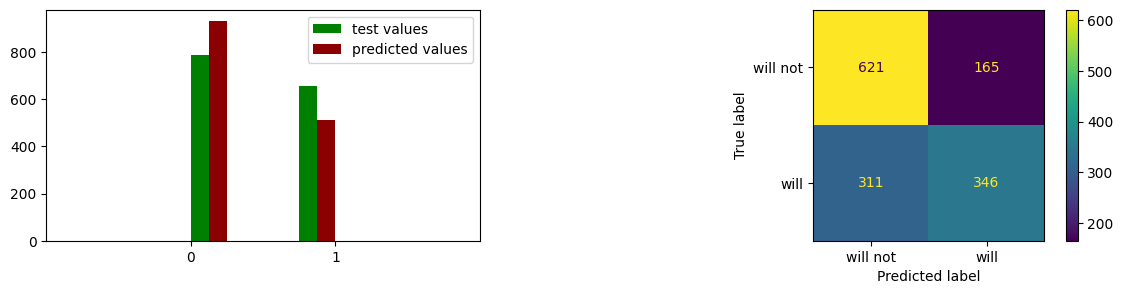

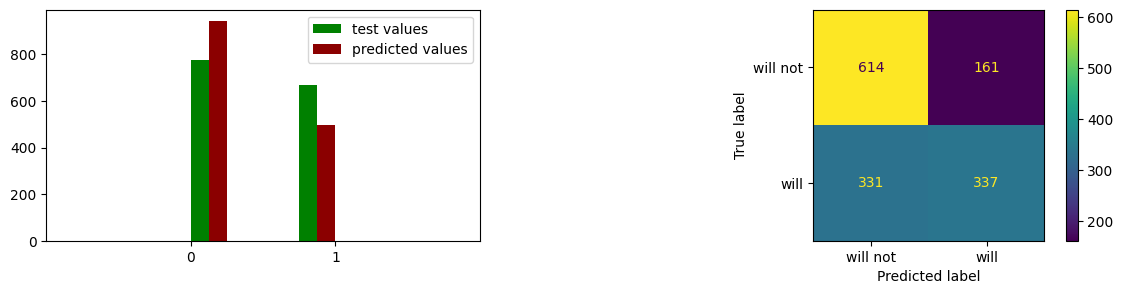

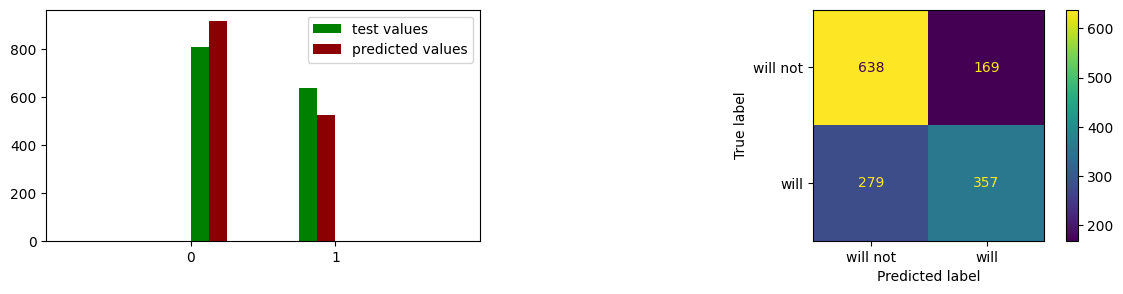

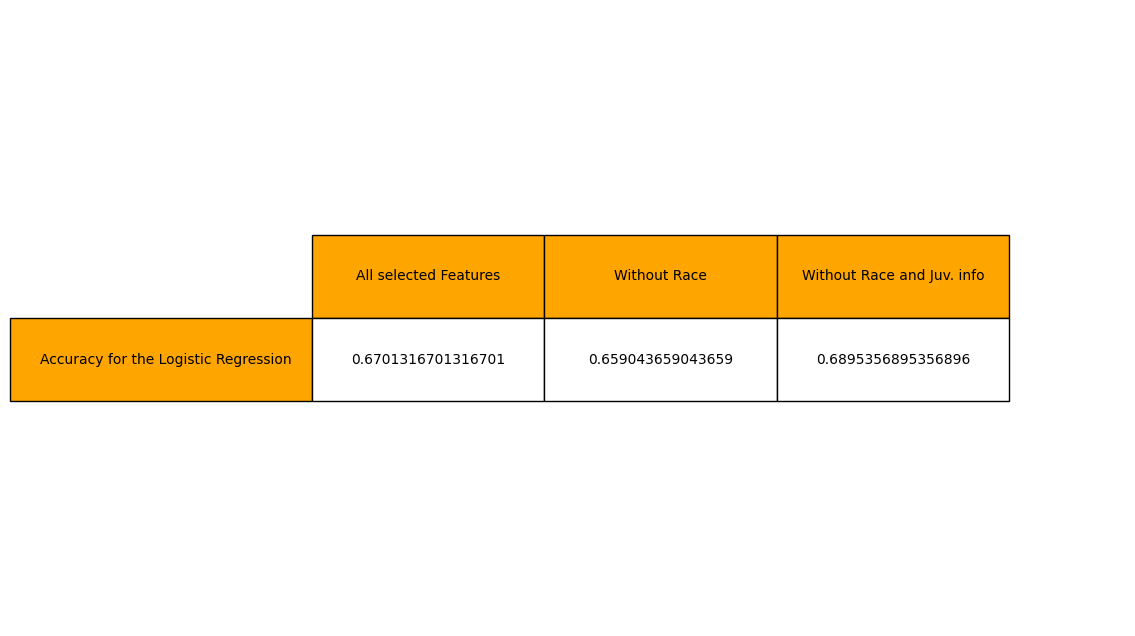

In [82]:
# Execute the routine on all the datasets.
y_true_1, y_pred_1 = routine(do_logistic_regression,
                             df_all,
                             "with all the features")
y_true_2, y_pred_2 = routine(do_logistic_regression,
                             df_wo_race,
                             "without races")
y_true_3, y_pred_3 = routine(do_logistic_regression,
                             df_wo_race_juv,
                             "without races and\njuvenile info")
# Also store the results to compare them after.
lr_true = [y_true_1, y_true_2, y_true_3]
lr_pred = [y_pred_1, y_pred_2, y_pred_3]
# Display the accuracy for each dataset.
display_accuracy(lr_true, lr_pred,
                 row=["Accuracy for the Logistic Regression"],
                 col=["All selected Features", "Without Race",
                      "Without Race and Juv. info"])


In [83]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [84]:
print(df.shape)
df.drop(["age"], axis=1, inplace=True)
df.drop(["name", "first", "last", "dob", "age_cat"], axis=1, inplace=True)
df.drop(["decile_score", "decile_score.1", "score_text",
         "v_decile_score", "v_score_text"],
        axis=1, inplace=True)
df.drop(["id", "compas_screening_date", "days_b_screening_arrest",
          "c_jail_in", "c_jail_out", "c_case_number", "screening_date",
          "v_type_of_assessment", "v_screening_date",
          "c_offense_date", "c_arrest_date",  "c_days_from_compas",
          "c_charge_desc", "r_jail_in", "r_jail_out", "r_days_from_arrest",
          "r_offense_date", "r_charge_desc", "r_case_number", "r_charge_degree",
          "violent_recid", "vr_case_number", "vr_charge_degree",
          "vr_offense_date", "vr_charge_desc", "type_of_assessment",
          "in_custody", "out_custody", "priors_count.1", "start", "end",
          "event", "is_recid"],
         axis=1, inplace=True)
print(df.shape)
df.head()

(7214, 53)
(7214, 9)


,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_violent_recid,two_year_recid
0,Male,Other,0,0,0,0,0,0,0
1,Male,African-American,0,0,0,0,0,1,1
2,Male,African-American,0,0,1,4,0,0,1
3,Male,African-American,0,1,0,1,0,0,0
4,Male,Other,0,0,0,2,0,0,0


In [85]:
def split_dataset(df_):
    X = df_
    y = df_.two_year_recid
    return skselect.train_test_split(X, y,
                                     random_state=0,
                                     train_size=0.8)


def display_metrics(y_true, y_pred, name):
    display_confusion_matrix(y_true, y_pred, title="Confusion matrix of a SVM (rbf)\n"
                             + "on our \"" + name + "\" dataset")
    display_accuracy([y_true], [y_pred],
                     row=["Accuracy for the SVM with RBF"],
                     col=["On the \"" + name + "\" dataset"])


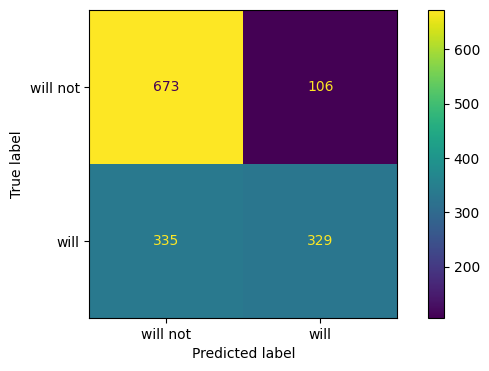

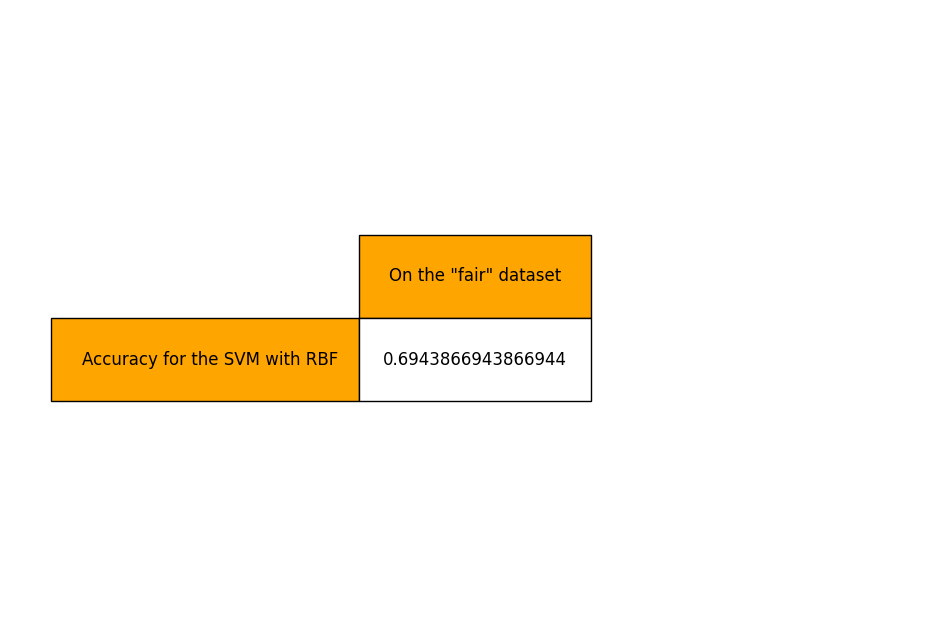

In [86]:
X_train, X_test, y_train, y_test = split_dataset(df)
X_train.drop(["sex", "race", "two_year_recid"], axis=1, inplace=True)
X_test_fair = X_test.drop(
    ["sex", "race", "two_year_recid"], axis=1, inplace=False)
# Then we create our SVC model.
fair_model = sksvm.SVC(kernel="rbf")
fair_model.fit(X_train, y_train)
# And we try it on our fair dataset.
y_pred = fair_model.predict(X_test_fair)
# Display the accuracy of the prediction, and confusion matrix.
display_metrics(y_test, y_pred, "fair")


In [87]:
def check_1(y_true, y_pred, name):
    """
    Check the disparate positive rates.
    """
    tn, fp, fn, tp = skmetrics.confusion_matrix(y_true, y_pred).ravel()
    result = (fp + tp) / (tn + fp + fn + tp)
    print("Disparate positive rates in the \"" + name + "\" dataset: %.2f"
          % result)


def check_2(y_true, y_pred, name):
    """
    Check the disparate true positives.
    """
    tn, fp, fn, tp = skmetrics.confusion_matrix(y_true, y_pred).ravel()
    result = (tp) / (tn + fp + fn + tp)
    print("Disparate true positives rate in the \"" + name + "\" dataset: %.2f"
          % result)


def check_3(y_true, y_pred, name):
    """
    Check the consistency.
    """
    tn, fp, fn, tp = skmetrics.confusion_matrix(y_true, y_pred).ravel()
    result1 = (fp + tp) / (tn + fp + fn + tp)
    result2 = (fn + tn) / (tn + fp + fn + tp)
    print("Consistency in the \"" + name + "\" dataset (positive/negative): %.2f/%.2f"
          % (result1, result2))


C:\Users\amanw\AppData\Local\Temp\ipykernel_9448\3654395403.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caucasian_X_test.drop(["sex", "race", "two_year_recid"], axis=1, inplace=True)
C:\Users\amanw\AppData\Local\Temp\ipykernel_9448\3654395403.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  africanam_X_test.drop(["sex", "race", "two_year_recid"], axis=1, inplace=True)


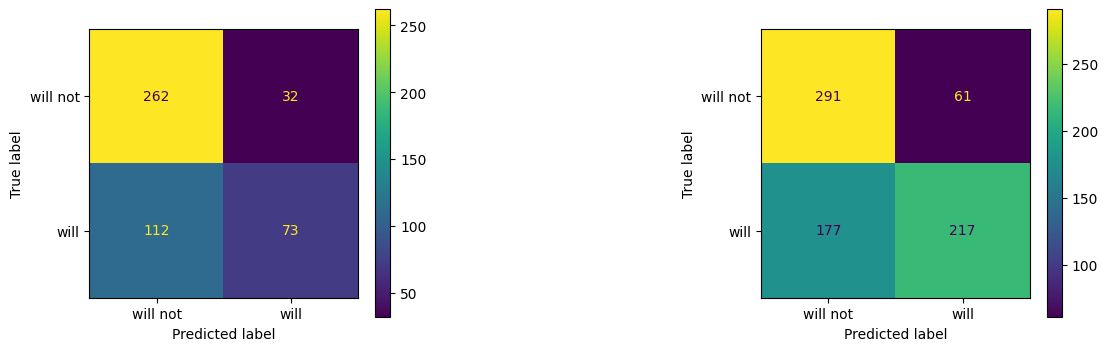

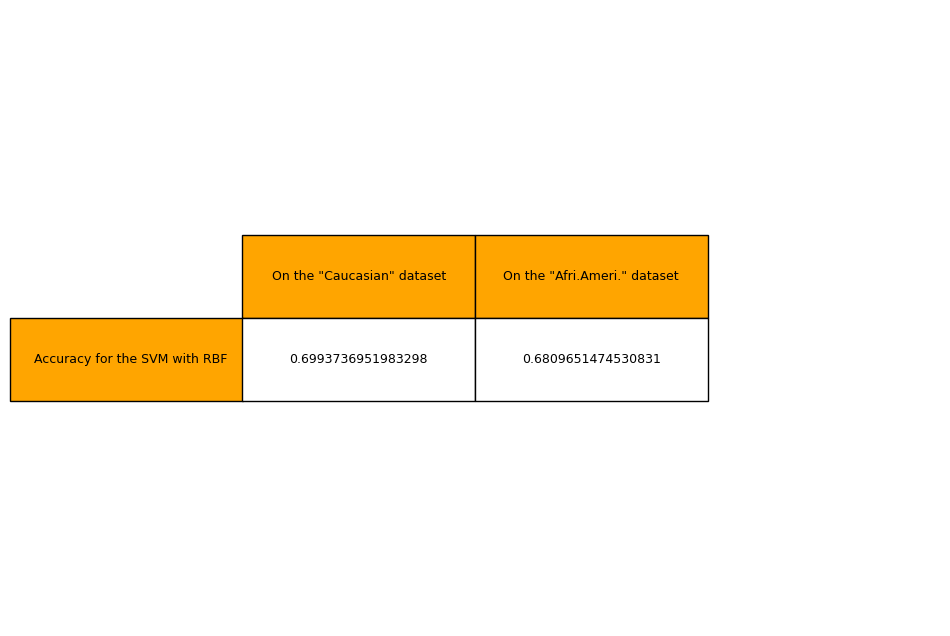

In [88]:
y_trues_race = []
y_preds_race = []
# We split our dataset on the race attribute.
caucasian_X_test = X_test[X_test.race == "Caucasian"]
africanam_X_test = X_test[X_test.race == "African-American"]
caucasian_y_test = caucasian_X_test.two_year_recid
africanam_y_test = africanam_X_test.two_year_recid
# Then we make it fair (as said before in note, etc).
caucasian_X_test.drop(["sex", "race", "two_year_recid"], axis=1, inplace=True)
africanam_X_test.drop(["sex", "race", "two_year_recid"], axis=1, inplace=True)

# And we predict and display confusion matrix for each set.
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(13, 4))
fig.subplots_adjust(wspace=1)

for X, y, name, ax in [(caucasian_X_test, caucasian_y_test, "Caucasians",        ax0),
                       (africanam_X_test, africanam_y_test, "African-Americans", ax1)]:

    y_pred = fair_model.predict(X)
    y_trues_race.append(y)
    y_preds_race.append(y_pred)
    # Display the confusion matrices.
    display_confusion_matrix(
        y, y_pred, title="on our \"" + name + "\" dataset", ax=ax)
# And then the accuracy.
display_accuracy(y_trues_race, y_preds_race,
                 row=["Accuracy for the SVM with RBF"],
                 col=["On the \"Caucasian\" dataset", "On the \"Afri.Ameri.\" dataset"])

C:\Users\amanw\AppData\Local\Temp\ipykernel_9448\1157396312.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fema_X_test.drop(["sex", "race", "two_year_recid"], axis=1, inplace=True)
C:\Users\amanw\AppData\Local\Temp\ipykernel_9448\1157396312.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_X_test.drop(["sex", "race", "two_year_recid"], axis=1, inplace=True)


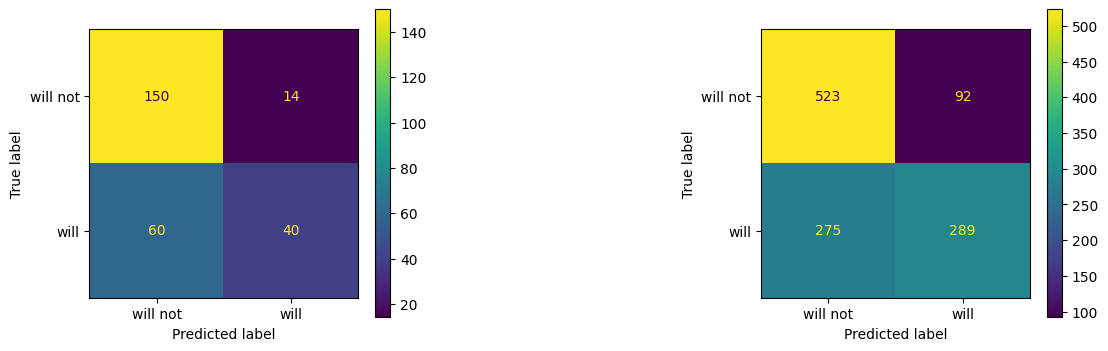

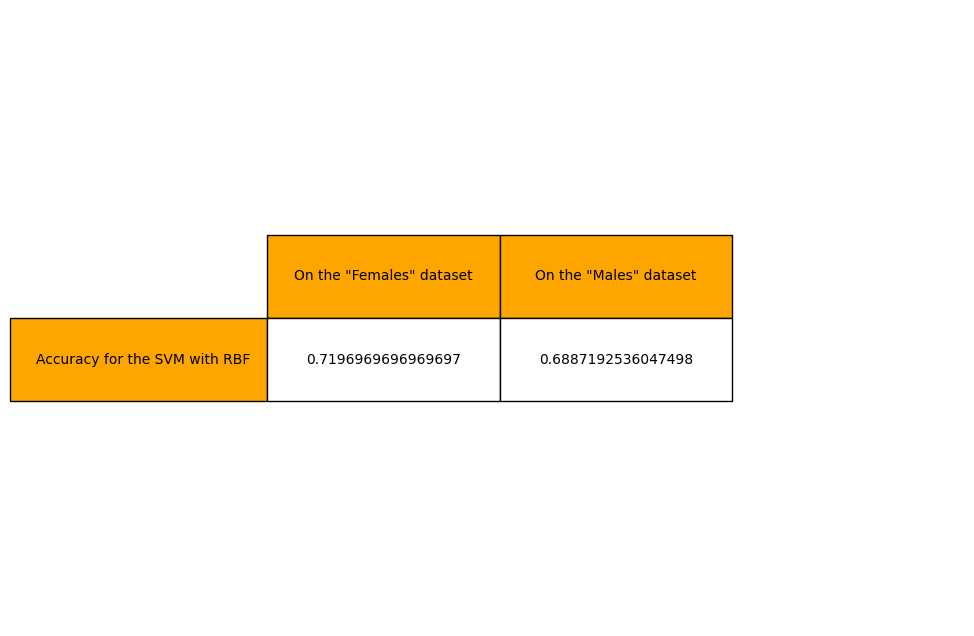

In [89]:
y_trues_sex = []
y_preds_sex = []
# We split our dataset on the sex attribute.
fema_X_test = X_test[X_test.sex == "Female"]
male_X_test = X_test[X_test.sex == "Male"]
fema_y_test = fema_X_test.two_year_recid
male_y_test = male_X_test.two_year_recid
# Then we make it fair (as said before in note, etc).
fema_X_test.drop(["sex", "race", "two_year_recid"], axis=1, inplace=True)
male_X_test.drop(["sex", "race", "two_year_recid"], axis=1, inplace=True)

# And we predict and display confusion matrix for each set.
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(13, 4))
fig.subplots_adjust(wspace=1)

for X, y, name, ax in [(fema_X_test, fema_y_test, "Females", ax0),
                       (male_X_test, male_y_test, "Males",   ax1)]:

    y_pred = fair_model.predict(X)
    y_trues_sex.append(y)
    y_preds_sex.append(y_pred)
    # Display the confusion matrices.
    display_confusion_matrix(
        y, y_pred, title="on our \"" + name + "\" dataset", ax=ax)
# And then the accuracy.
display_accuracy(y_trues_sex, y_preds_sex,
                 row=["Accuracy for the SVM with RBF"],
                 col=["On the \"Females\" dataset", "On the \"Males\" dataset"])


In [90]:
print("\n\n----------------------------------------------\n"
      + "For the races:")

for y_true, y_pred, name in zip(y_trues_race, y_preds_race, ["Caucasians", "African-Americans"]):
    print("--------------")
    check_1(y_true, y_pred, name)
    check_2(y_true, y_pred, name)
    check_3(y_true, y_pred, name)

print("\n\n----------------------------------------------\n"
      + "For the sexes:")

for y_true, y_pred, name in zip(y_trues_sex, y_preds_sex, ["Females", "Males"]):
    print("--------------")
    check_1(y_true, y_pred, name)
    check_2(y_true, y_pred, name)
    check_3(y_true, y_pred, name)




----------------------------------------------
For the races:
--------------
Disparate positive rates in the "Caucasians" dataset: 0.22
Disparate true positives rate in the "Caucasians" dataset: 0.15
Consistency in the "Caucasians" dataset (positive/negative): 0.22/0.78
--------------
Disparate positive rates in the "African-Americans" dataset: 0.37
Disparate true positives rate in the "African-Americans" dataset: 0.29
Consistency in the "African-Americans" dataset (positive/negative): 0.37/0.63


----------------------------------------------
For the sexes:
--------------
Disparate positive rates in the "Females" dataset: 0.20
Disparate true positives rate in the "Females" dataset: 0.15
Consistency in the "Females" dataset (positive/negative): 0.20/0.80
--------------
Disparate positive rates in the "Males" dataset: 0.32
Disparate true positives rate in the "Males" dataset: 0.25
Consistency in the "Males" dataset (positive/negative): 0.32/0.68
